# Documentation

Tuto classif avec camembert : https://xiaoouwang.medium.com/classification-de-commentaires-avec-camembert-sans-prise-de-t%C3%AAte-les-fondamentaux-dbf8070f679b  
Tuto fine-tuning avec sentence-bert : https://h4c5.hashnode.dev/finetuner-un-modele-camembert-pour-lembedding-de-phrases  
Tuto fine-tuning Camembert pour NER : https://www.quantmetry.com/blog/fine-tune-modele-bert-tache-ner/  
Article expliquant les Transformers : https://www.hugomichel.io/post/transformer/  
Huggingface Camembert : https://huggingface.co/docs/transformers/model_doc/camembert#transformers.CamembertModel  
Article sur la fonction de coût pour classification multi-label : https://medium.com/@kitkat73275/multi-label-classification-8d8ae55e8373  
Implémentation de la fonction de coût dans un modèle DL : https://machinelearningmastery.com/multi-label-classification-with-deep-learning/  
Utilisation de torch.eval() pour bien évaluer un modèle pytroch : https://iifx.dev/en/articles/267524756  

In [31]:
!pip install transformers
!pip install sentencepiece
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.0 MB/s eta 0:00:00


# Imports

In [126]:
# Misc
import os
import s3fs
from itertools import compress
import time

# pre-trained Model
from transformers import CamembertTokenizer, CamembertForSequenceClassification

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F

# Data

In [3]:
os.environ["AWS_S3_ENDPOINT"]
S3_ENDPOINT_URL  = 'https://'+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs = {'endpoint_url' : S3_ENDPOINT_URL})
fs.ls('')

['nsimonovici-ensae']

In [4]:
BUCKET = "nsimonovici-ensae"
DIR_KEY_S3 = "PROJET/data/"
FILE_KEY_S3 = 'project-1-at-2024-12-27-15-41-3fe0002a_prepared.csv'
s3_path = f"s3a://{BUCKET}/{DIR_KEY_S3}{FILE_KEY_S3}"
s3_path

's3a://nsimonovici-ensae/PROJET/data/project-1-at-2024-12-27-15-41-3fe0002a_prepared.csv'

In [5]:
with fs.open(s3_path, mode = 'r') as file_in : 
    data_raw = pd.read_csv(file_in, sep=";")

print(f"{data_raw.shape[0]} Lignes et {data_raw.shape[1]} Colonnes")
data_raw.head()

1263 Lignes et 10 Colonnes


,inner_id,topic,topic_idx,data.text,data.name,file_upload,id,data.url,data.username,data.date
0,1,"[""social""]",[11],Stop #ViolenceAgainstWomen!\n\n#OrangeTheWorld...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,1,https://bsky.app/profile/fabiennekeller.bsky.s...,ensembleue.bsky.social,2024-11-25 19:25:10.459000
1,2,"[""social""]",[11],La violence à l’égard des femmes reste une urg...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,2,https://bsky.app/profile/mariepierrev.bsky.soc...,ensembleue.bsky.social,2024-11-25 19:24:48.661000
2,3,"[""international"",""économie""]","[8,3]","« Notre position sur le Mercosur, depuis 2019,...",L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,3,https://bsky.app/profile/ensembleue.bsky.socia...,ensembleue.bsky.social,2024-11-25 13:42:39.117000
3,4,"[""international"",""économie"",""social""]","[8,3,11]",Nouvelle session plénière à Strasbourg ! À l’o...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,4,https://bsky.app/profile/ensembleue.bsky.socia...,ensembleue.bsky.social,2024-11-25 12:59:05.431000
4,5,"[""international"",""immigration""]","[8,7]",Désaveu cinglant pour Meloni qui se résout à r...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,5,https://bsky.app/profile/fabiennekeller.bsky.s...,ensembleue.bsky.social,2024-11-25 12:50:04.455000


# CamemBert

In [7]:
# # tokenizer = AutoTokenizer.from_pretrained("almanach/camembert-base")
# model = CamembertModel.from_pretrained("almanach/camembert-base")

In [ ]:
# model.state_dict().keys() # Affiche les poids

In [ ]:
# for module in model.modules(): # Affiche les 'modules' dont les couches
#     print(module)

## Entraînement ou non des couches cachées
Les couches sont toutes trainable de base.  
On veut les rendre non-trainable pour le fine-tuning avec un petit jeu de données  
Voir cet article qui discute du sujet : https://discuss.huggingface.co/t/the-point-of-using-pretrained-model-if-i-dont-freeze-layers/40675

In [8]:
# for param in model.parameters():
#     param.requires_grad = False

In [9]:
# print(f"num params:", model.num_parameters())
# print(f"num trainable params:", model.num_parameters(only_trainable=True))

## Fonction de coût :  
What you want is multi-label classification, so you will use Binary Cross-Entropy Loss or Sigmoid Cross-Entropy loss. It is a Sigmoid activation plus a Cross-Entropy loss. Unlike Softmax loss it is independent for each vector component (class), meaning that the loss computed for every CNN output vector component is not affected by other component values. That’s why it is used for multi-label classification, where the insight of an element belonging to a certain class should not influence the decision for another class.

## Altération du model : couches de fine-tuning

In [10]:
# def get_finetuning_model(n_outputs):
# 	model = Sequential()
# 	model.out = Linear(n_outputs, activation='sigmoid')
# 	model.compile(loss='binary_crossentropy', optimizer='adam')
# 	return model

In [67]:
# model.fineTuning = get_finetuning_model(16)

# Fine-Tuning

## Chargement du modèle et du tokenizer

In [45]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=16, problem_type="multi_label_classification")

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
print(f"num params:", model.num_parameters())
print(f"num trainable params:", model.num_parameters(only_trainable=True))

num params: 110634256
num trainable params: 110634256


Utilisation des "named_modules" pour identifier le classifieur à la tête du réseau

In [47]:
for mod_name, mod in model.named_modules():
    if len(mod_name) > 0:
        if not mod_name.startswith('classifier'):
            print(f"Setting module ***{mod_name}*** non-trainable")
            for param in mod.parameters():
                param.requires_grad = False
        else:
            print(f"Letting module ***{mod_name}*** trainable")

Setting module ***roberta*** non-trainable
Setting module ***roberta.embeddings*** non-trainable
Setting module ***roberta.embeddings.word_embeddings*** non-trainable
Setting module ***roberta.embeddings.position_embeddings*** non-trainable
Setting module ***roberta.embeddings.token_type_embeddings*** non-trainable
Setting module ***roberta.embeddings.LayerNorm*** non-trainable
Setting module ***roberta.embeddings.dropout*** non-trainable
Setting module ***roberta.encoder*** non-trainable
Setting module ***roberta.encoder.layer*** non-trainable
Setting module ***roberta.encoder.layer.0*** non-trainable
Setting module ***roberta.encoder.layer.0.attention*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self.query*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self.key*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self.value*** non-trainable
Setting m

In [48]:
print(f"num params:", model.num_parameters())
print(f"num trainable params:", model.num_parameters(only_trainable=True))

num params: 110634256
num trainable params: 602896


In [49]:
for module in model.modules(): # Affiche les 'modules' dont les couches
    print(module)

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

In [50]:
# help(module)

In [51]:
model

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

## Préparation des données
- Assurez-vous que vos données sont sous forme de texte et de labels multi-labels (par exemple, une liste de listes de labels).
- Tokenisez les textes et convertissez les labels en tenseurs PyTorch.

In [76]:
dict_labels_index = {'autre':0,
    'culture et médias':1,
    'environnement':2,
    'économie':3,
    'éducation':4,
    'fiscalité':5,
    'institutions':6,
    'immigration':7,
    'international':8,
    'outre-mer':9,
    'pouvoir d’achat':10,
    'social':11,
    'services publics':12,
    'santé':13,
    'sécurité / justice':14,
    'vie politique':15}

dict_index_labels = {value:key for key, value in dict_labels_index.items()}

In [11]:
texts = data_raw['data.text'].tolist()
print(len(texts))
texts[0]

1263


'Stop #ViolenceAgainstWomen!\n\n#OrangeTheWorld \n\n📍 Parlement européen, Strasbourg 🧡'

In [12]:
labels_arr = np.zeros((len(texts), 16))
labels_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1263, 16))

In [13]:
labels_raw = data_raw['topic_idx'].tolist()
labels_ints = []
for labs in labels_raw:
    labels_ints.append([int(value) for value in labs.replace('[', '').replace(']', '').split(',')])
labels_ints[:5]

[[11], [11], [8, 3], [8, 3, 11], [8, 7]]

In [14]:
for i in range(labels_arr.shape[0]):
    labs = labels_ints[i]
    for value in labs:
        labels_arr[i, value] = 1
labels_arr        

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(1263, 16))

In [15]:
labels_list = labels_arr.tolist()
labels_list[:5]

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

### Split train/test/val

In [127]:
random_state = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(texts, labels_list, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=random_state)

print(f"Taille jeu d'entraînement = {len(X_train)}")
print(f"Taille jeu de validation = {len(X_val)}")
print(f"Taille jeu de test = {len(X_test)}")

Taille jeu d'entraînement = 909
Taille jeu de validation = 101
Taille jeu de test = 253


In [17]:
inputs_train = tokenizer(X_train, padding=True, truncation=True, return_tensors="pt")
labels_train = torch.tensor(y_train)
inputs_val = tokenizer(X_val, padding=True, truncation=True, return_tensors="pt")
labels_val = torch.tensor(y_val)
inputs_test = tokenizer(X_test, padding=True, truncation=True, return_tensors="pt")
labels_test = torch.tensor(y_test)

## Création du DataLoader

In [52]:
batch_size = 32

dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Définition de l'optimiseur et de la fonction de perte

In [128]:
learning_rate = 5e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = BCEWithLogitsLoss()

## Entraînement du modèle

Fonction de calcul de métrique pour de la classification multi-label

In [54]:
def compute_metrics(y_pred, y_true, threshold=0.5):
    # Get probabilities from logits with sigmoid
    probabilities = F.sigmoid(y_pred.logits)
    
    # Apply threshold for binary answer for each class
    predictions = (probabilities > threshold).int()
    
    # Exact Match Ratio
    acc = accuracy_score(y_true, predictions, normalize=True, sample_weight=None)
    # Hamming loss
    hl = hamming_loss(y_true, predictions)
    
    #"samples" applies only to multilabel problems. It does not calculate a per-class measure, instead calculating the metric over the true and predicted classes 
    #for each sample in the evaluation data, and returning their (sample_weight-weighted) average.
    # Recall
    precision = precision_score(y_true=y_true, y_pred=predictions, average='samples')
    # Precision
    recall = recall_score(y_true=y_true, y_pred=predictions, average='samples')
    # F1 Measure
    f1 = f1_score(y_true=y_true, y_pred=predictions, average='samples')

    return acc, hl, recall, precision, f1

### Paramètres d'entraînement  

Article pour choisir les hyper paramètres : https://mccormickml.com/2019/07/22/BERT-fine-tuning/#42-optimizer--learning-rate-scheduler

In [55]:
n_epochs = 20
threshold_train = 0.5

### Entraînement

In [ ]:
# Initialize metrics
dict_metrics = {'accuracy': [],
                'hamming': [],
                'recall': [],
                'precision': [],
                'f1': [],
                'loss_train': [],
                'loss_val': []
               }

preds_val = []

start_time = time.time()

for epoch in range(n_epochs):  # Nombre d'époques
    model.train() # Ensure to set model in training mode at the start of the epoch
    print("Starting training for epoch number ", epoch)
    
    for batch in dataloader:
       input_ids, attention_mask, labels = batch
       outputs = model(input_ids, attention_mask=attention_mask)
       logits = outputs.logits
       loss = loss_fn(logits, labels.float())

       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
       
       # print(f"Loss: {loss.item()}")

    # Evaluation step during training
    # Following this article : https://iifx.dev/en/articles/267524756
    # Calling torch.no_grad and setting model.eval because dropout and normalization layers behave differtently in validation than training
    with torch.no_grad():
        model.eval()
        
        # Training loss
        y_pred_train = model(inputs_train['input_ids'], attention_mask=inputs_train['attention_mask'])
        loss_train = loss_fn(y_pred_train.logits, labels_train)
        
        # evaluate model at end of epoch with validation set
        y_pred_val = model(inputs_val['input_ids'], attention_mask=inputs_val['attention_mask'])
        loss_val = loss_fn(y_pred_val.logits, labels_val)
        accuracy_val, hamming_loss_val, recall_val, precision_val, f1score_val = compute_metrics(y_pred_val, y_val, threshold=threshold_train)
    
        # Saving epoch metric for later plotting
        preds_val.append(y_pred_val)
        dict_metrics['accuracy'].append(accuracy_val)
        dict_metrics['hamming'].append(hamming_loss_val)
        dict_metrics['recall'].append(recall_val)
        dict_metrics['precision'].append(precision_val)
        dict_metrics['f1'].append(f1score_val)
        dict_metrics['loss_train'].append(loss_train.detach().numpy())
        dict_metrics['loss_val'].append(loss_val.detach().numpy())
    
        print(f"End of epoch number {epoch}")
        print(f"   Loss train {loss_train:.4f}")
        print(f"   Loss val {loss_val:.4f}")
        print(f"   Accuracy {accuracy_val:.4f}")
        print(f"   Hamming Loss {hamming_loss_val:.4f}")
        print(f"   Recall {recall_val:.4f}")
        print(f"   Precision {precision_val:.4f}")
        print(f"   F1-Score {f1score_val:.4f}")

end_time = time.time()
total_time = end_time - start_time

print(f"Total training time {total_time / 60} minutes")

Starting training for epoch number  0


### Métriques et descente de gradient

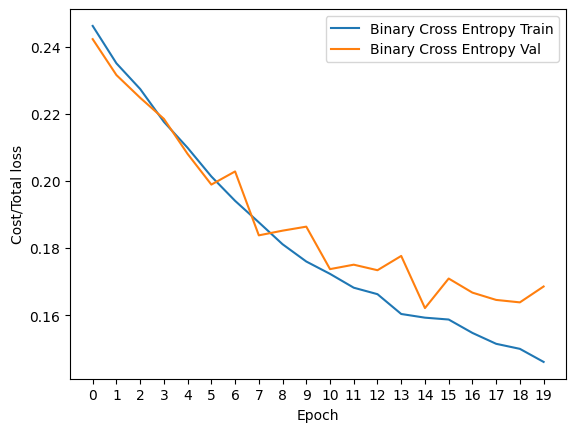

In [60]:
plt.plot(range(len(dict_metrics['loss_train'])), dict_metrics['loss_train'], label="Binary Cross Entropy Train")
plt.plot(range(len(dict_metrics['loss_val'])), dict_metrics['loss_val'], label="Binary Cross Entropy Val")
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.xticks(range(len(dict_metrics['loss_train'])))
plt.legend();

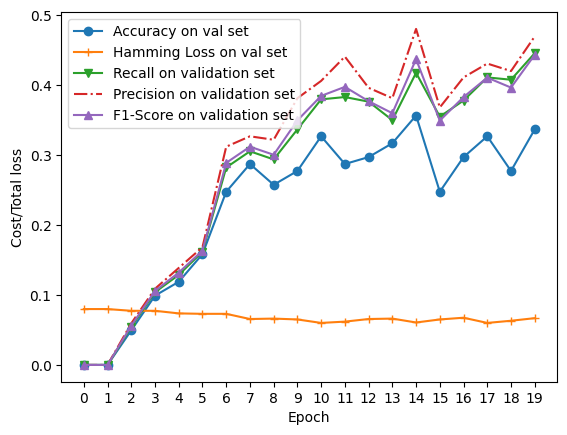

In [73]:
plt.plot(range(len(dict_metrics['accuracy'])), dict_metrics['accuracy'], label="Accuracy on val set", linestyle = 'solid', marker = 'o')
plt.plot(range(len(dict_metrics['hamming'])), dict_metrics['hamming'], label="Hamming Loss on val set", linestyle = 'solid', marker = '+')
plt.plot(range(len(dict_metrics['recall'])), dict_metrics['recall'], label="Recall on validation set", linestyle = 'solid', marker = 'v')
plt.plot(range(len(dict_metrics['precision'])), dict_metrics['precision'], label="Precision on validation set", linestyle = '-.')
plt.plot(range(len(dict_metrics['f1'])), dict_metrics['f1'], label="F1-Score on validation set", linestyle = 'solid', marker = '^')
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.xticks(range(len(dict_metrics['loss_train'])))
plt.legend();

## Évaluation du modèle sur le jeu de test
Après l'entraînement, évalueation du modèle sur un jeu de données de test pour vérifier ses performances

### Métriques

In [74]:
model.eval()
# Code pour évaluer le modèle sur un jeu de données de test

threshold_test = 0.5

y_pred_test = model(inputs_test['input_ids'], attention_mask=inputs_test['attention_mask'])
loss_test = loss_fn(y_pred_test.logits, labels_test)
accuracy_test, hamming_loss_test, recall_test, precision_test, f1score_test = compute_metrics(y_pred_test, y_test, threshold=threshold_test)

print(f"   Loss test {loss_test:.4f}")
print(f"   Accuracy {accuracy_test:.4f}")
print(f"   Hamming Loss {hamming_loss_test:.4f}")
print(f"   Recall {recall_test:.4f}")
print(f"   Precision {precision_test:.4f}")
print(f"   F1-Score {f1score_test:.4f}")

   Loss test 0.1668
   Accuracy 0.3597
   Hamming Loss 0.0635
   Recall 0.4592
   Precision 0.5224
   F1-Score 0.4754


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Enregistrement des expérimentations

In [154]:
# l_cols_results = [
#     'comment',
#     'dataset',
#     'train_size',
#     'val_size',
#     'test_size',
#     'split_method',
#     'split_seed',
#     'batch_size',
#     'learning_rate',
#     'number_epochs',
#     'threshold',
#     'training_time',
#     'bce_loss_train',
#     'bce_loss_val',
#     'bce_loss_test',
#     'accuracy_test',
#     'hamming_loss_test',
#     'recall_test',
#     'precision_test',
#     'f1score_test'
# ]

# df_results = pd.DataFrame(columns=l_cols_results)

df_results = pd.read_csv("results.csv", sep=";")

#### PARAGRAPHE A MODIFIER A CHAQUE ESSAI ####
dict_new_row = {
    'comment': "Le modèle apprend mais les métriques sont mauvaises et les classes sous-représentées mal apprises",
    'dataset': FILE_KEY_S3,
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'split_method': 'train_test',
    'split_seed': random_state,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'number_epochs': n_epochs,
    'threshold': threshold_train,
    'training_time': None,
    'bce_loss_train': dict_metrics['loss_train'],
    'bce_loss_val': dict_metrics['loss_val'],
    'bce_loss_test': loss_test.detach().numpy(),
    'accuracy_test': accuracy_test,
    'hamming_loss_test': hamming_loss_test,
    'recall_test': recall_test,
    'precision_test': precision_test,
    'f1score_test': f1score_test
}

df_new_row = pd.DataFrame([new_row])
df_results = pd.concat((df_results, df_new_row))

df_results.to_csv("results.csv", sep=';', index=False)

df_results

/tmp/ipykernel_877/2505584026.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat((df_results, df_new_row))


,comment,dataset,train_size,val_size,test_size,split_method,split_seed,batch_size,learning_rate,number_epochs,threshold,training_time,bce_loss_train,bce_loss_val,bce_loss_test,accuracy_test,hamming_loss_test,recall_test,precision_test,f1score_test
0,Le modèle apprend mais les métriques sont mauv...,project-1-at-2024-12-27-15-41-3fe0002a_prepare...,909,101,253,train_test,42,32,0.0005,20,0.5,None,"[0.24619417, 0.23504612, 0.22739978, 0.2176115...","[0.24225658, 0.23155232, 0.22478296, 0.2184975...",0.16675052,0.359684,0.063488,0.459157,0.522398,0.475362


### Observation des prédictions

In [89]:
probabilities_test = F.sigmoid(y_pred_test.logits).detach().numpy()

df_probas_pred_test = pd.DataFrame(probabilities_test, columns=dict_labels_index.keys())
df_probas_pred_test.head()

,autre,culture et médias,environnement,économie,éducation,fiscalité,institutions,immigration,international,outre-mer,pouvoir d’achat,social,services publics,santé,sécurité / justice,vie politique
0,0.009930,0.006116,0.073612,0.389544,0.001929,0.005445,0.036718,0.018437,0.989494,0.013052,0.005465,0.007304,0.002381,0.006093,0.010386,0.048112
1,0.009813,0.010611,0.039701,0.150241,0.059290,0.032548,0.179130,0.028563,0.002726,0.010626,0.200463,0.835798,0.035631,0.147512,0.044151,0.050591
2,0.046366,0.005740,0.010368,0.039657,0.004960,0.007059,0.093304,0.012421,0.013949,0.004800,0.012522,0.025375,0.003121,0.008295,0.006128,0.912954
3,0.005613,0.005877,0.020489,0.023679,0.008772,0.007386,0.246761,0.024568,0.023755,0.004494,0.015223,0.128396,0.003793,0.015090,0.020544,0.803107
4,0.049613,0.012334,0.022397,0.045206,0.027015,0.012005,0.048087,0.018275,0.009589,0.012277,0.039211,0.491199,0.014106,0.062585,0.057745,0.107427


In [125]:
for text in X_test[:5]:
    print(text)
    print("-------------------------------")

Guerre en Ukraine : l’Allemagne va doubler son aide militaire à Kiev en 2024
Le ministre allemand de la Défense a annoncé dimanche le versement de 8 milliards d’euros pour aider militairement l’Ukraine en 2024.
-------------------------------
✊ Aux côtés des syndicats, en soutien aux fonctionnaires et aux services publics, contre les coupes budgétaires : le jeudi 5 décembre, marchons !

✍️ Signez la pétition pour dire non à la casse des services publics : parti-socialiste.fr/sauvons_les_...

#SauvonsLesServicesPublics
-------------------------------
"Un gouvernement de menteurs et d'incompétents".
Léon Deffontaines invité de la matinale de CNEWS
#gouvernement #europe
 youtube.com/live/GbktguV...
-------------------------------
🚀 La dynamique est lancée !

Dans le sondage Ipsos pour @lemonde.fr, notre liste conduite par Raphaël Glucksmann confirme sa place en tête des intentions de vote à gauche.

Pour ces élections européennes, nous sommes la seule alternative à la droite conservatrice

In [106]:
df_test = pd.DataFrame(labels_test.numpy().astype(bool), columns=dict_labels_index.keys())
ser_labels_test = df_test.apply(lambda row: list(compress(l_labels, row)), axis=1)
ser_labels_test

0                       [international]
1                    [services publics]
2                       [vie politique]
3                [institutions, social]
4                              [social]
                     ...               
248                   [pouvoir d’achat]
249    [international, pouvoir d’achat]
250            [économie, institutions]
251                     [vie politique]
252                             [autre]
Length: 253, dtype: object

In [105]:
l_labels = list(dict_labels_index.keys())
ser_labels_pred_test = (df_probas_pred_test > threshold_test).apply(lambda row: list(compress(l_labels, row)), axis=1)
ser_labels_pred_test

0      [international]
1             [social]
2      [vie politique]
3      [vie politique]
4                   []
            ...       
248                 []
249                 []
250                 []
251                 []
252           [social]
Length: 253, dtype: object

### Conclusions des observations

On peut penser que certaines classes portent le poids d'un apprentissage sémantique propre à leur source comme évoqué en projet tutoré.  
Cela semble entraîner de mauvaises prédictions

### Matrices de confusion par classe

In [113]:
y_pred_test_np_threshold = (df_probas_pred_test > threshold_test).astype(int).to_numpy()

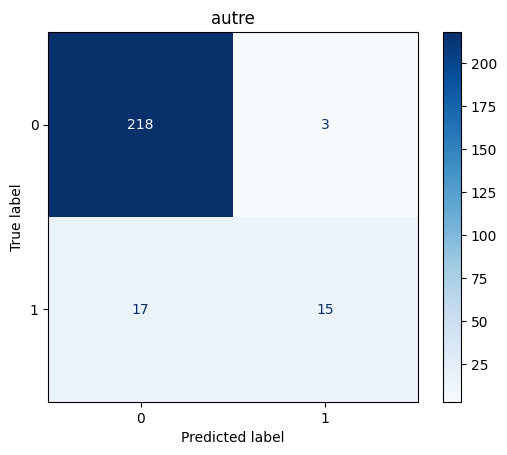

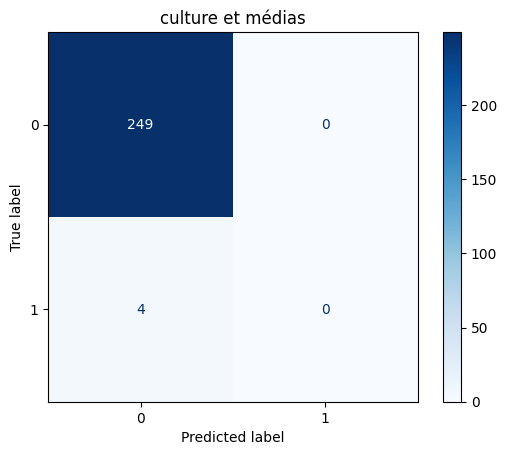

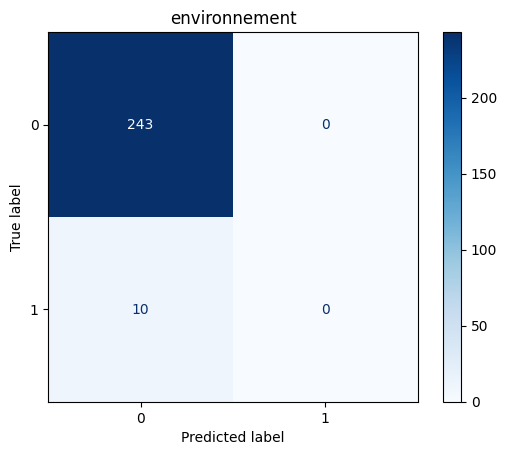

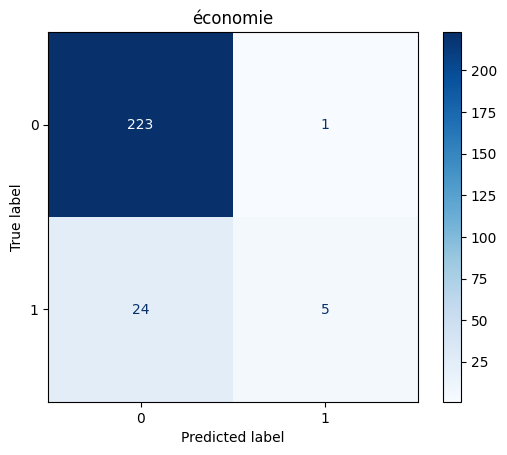

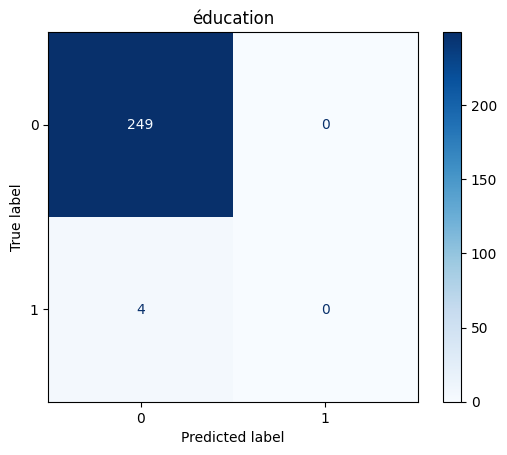

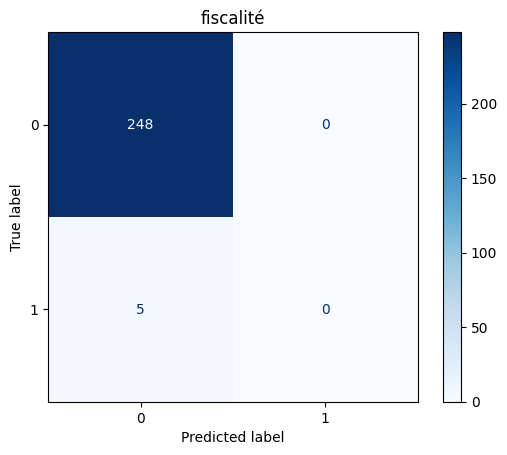

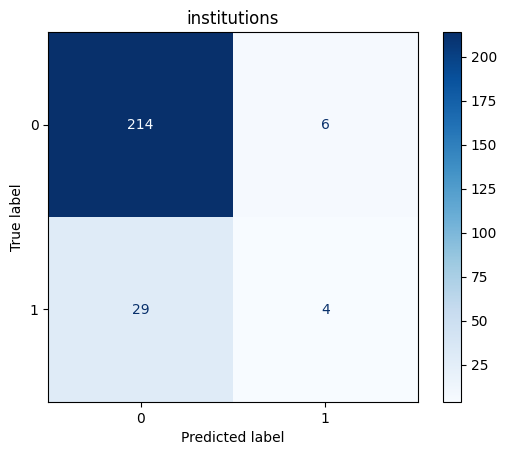

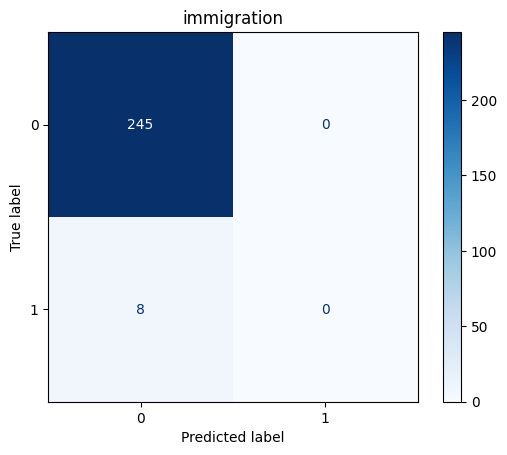

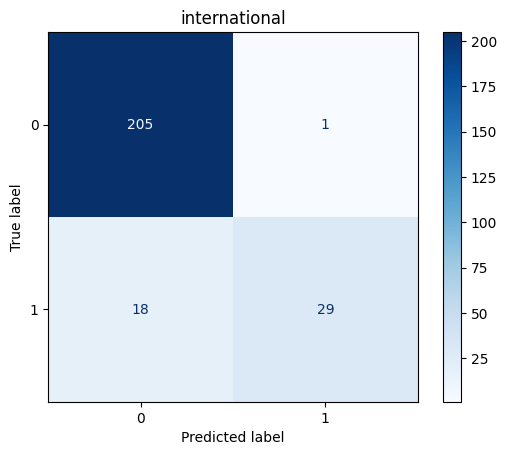

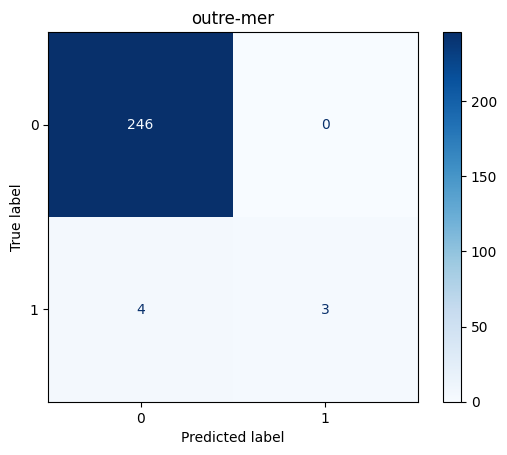

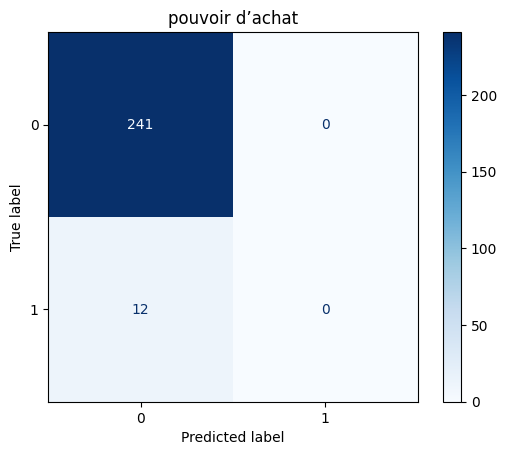

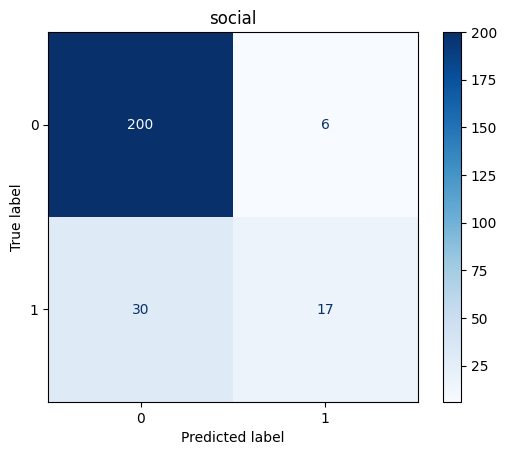

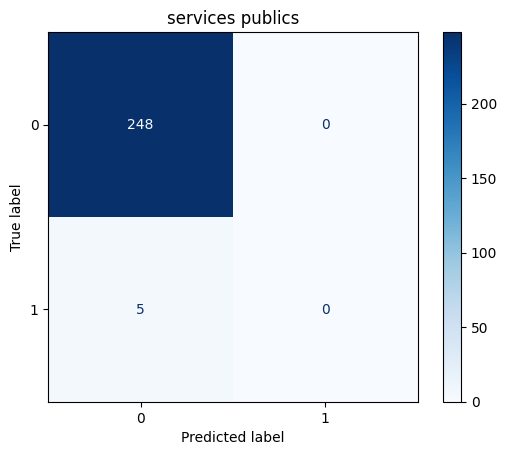

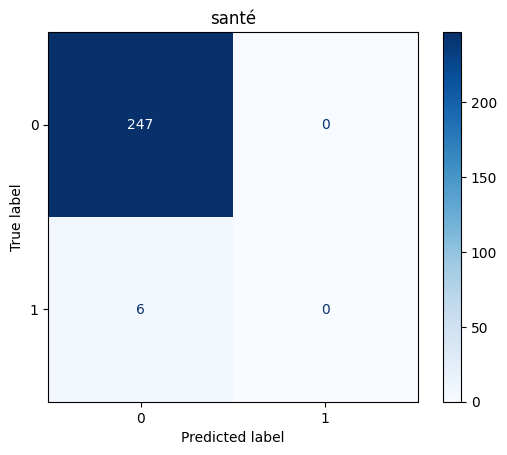

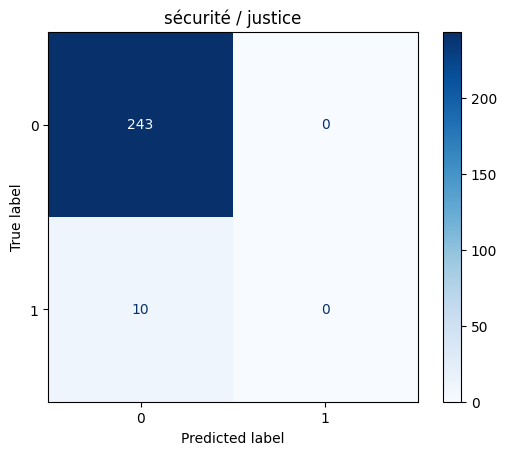

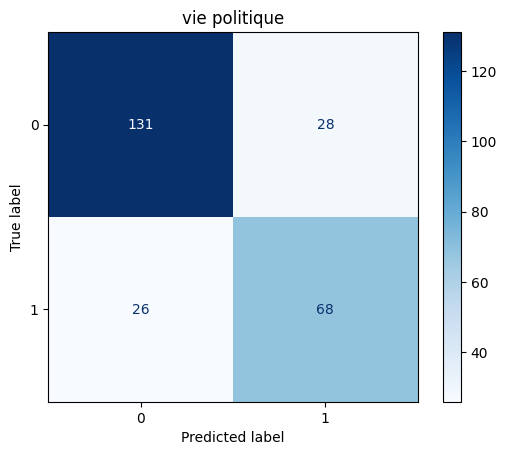

In [121]:
arr_cm = multilabel_confusion_matrix(y_test, y_pred_test_np_threshold)

for label, cm in zip(l_labels, arr_cm):
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(label)
    plt.show()